In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

catsndogs = pd.read_csv('data\CATSnDOGS.csv')
labels = pd.read_csv('data\Labels.csv')



### Some exploration...

Cat labels = 97, Dog labels = 101. <- Indicates mislabeling, supposed to be 99 of each!


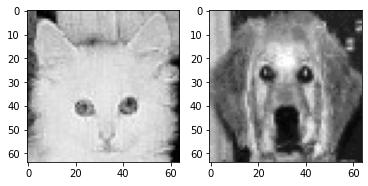

In [156]:

cat_ids = np.nonzero(labels.values[:,0]==0)[0] #[0] to get into tuple
dog_ids = np.nonzero(labels.values[:,0]==1)[0]

print(f'Cat labels = {len(cat_ids)}, Dog labels = {len(dog_ids)}. <- Indicates mislabeling, supposed to be 99 of each!')

catid = np.random.choice(cat_ids)
dogid = np.random.choice(dog_ids)

cat = catsndogs.iloc[180].to_numpy().reshape((64,64), order='F')
dog = catsndogs.iloc[dogid].to_numpy().reshape((64,64), order='F')

fig, axs = plt.subplots(1, 2)
axs[0].imshow(cat, cmap='gray')
axs[1].imshow(dog, cmap='gray')
plt.show()


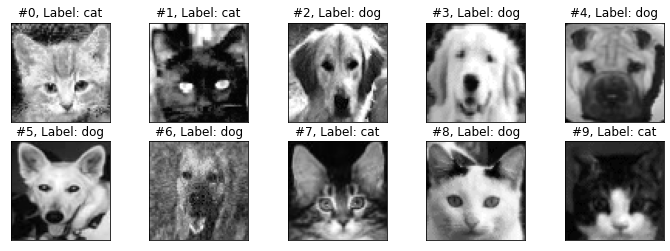

In [36]:
names = ['cat', 'dog']

fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(12, 4))

for i, axr in enumerate(axs):
    for j, ax in enumerate(axr):
        ax.imshow(catsndogs.iloc[i*len(axr)+j].to_numpy().reshape((64,64), order='F'), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title(f'#{i*len(axr)+j}, Label: {names[labels.values[i*len(axr)+j,0]]}')

# Question 1 (60p)



## 1a (10p)
 - Are the cats and dogs well separated, i.e. can you obtain good classification test accuracy performance on this data set? Compare at least 3 classifiers.

 - Are there any images that are consistently mislabeled by the classifiers (use resampling to ascertain)? Why do you think these are difficult images to classify? Do the classifiers struggle with the same observations?

 - Are the errors balanced or is one class more difficult to classify correctly?

In [6]:
# First we try to classify, using 3 classifiers
# Maybe Linear regression, QDA(?), and kNN?

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

def analyze_separation(data, labels, repetitions=20, return_train=False):
    test_accuracies = {
        'knn': 0,
        'lr': 0,
        'rf': 0
    }

    train_accuracies = {
        'knn': 0,
        'lr': 0,
        'rf': 0
    }

    test_mislab = {
        'knn': [],
        'lr': [],
        'rf': []
    }

    train_mislab = {
        'knn': [],
        'lr': [],
        'rf': []
    }

    if type(labels)==np.ndarray:
        labels = pd.DataFrame(labels)
        print(f'Converted to DF: {labels}')

    
    knn = KNeighborsClassifier(n_neighbors=7)
    lr = LogisticRegression(max_iter=500)
    rf = RandomForestClassifier()


    for i in range(repetitions):
        x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2)

        #print('x: ', x_train.shape)
        #print('y: ', y_train.shape)
        # kNN
        knn.fit(x_train, y_train.values[:,0])
        knn_y_pred = knn.predict(x_test)
        #print(f'test: {np.sum(knn_y_pred==y_test.values[:,0])} len: {len(y_test)}')
        test_accuracies['knn'] += np.sum(knn_y_pred==y_test.values[:,0])/len(y_test) /repetitions
        test_mislab['knn'].extend(y_test.index[(knn_y_pred!=y_test.values[:,0])].to_list())

        # Linear regression
        lr.fit(x_train, y_train.values[:,0])
        lr_y_pred = lr.predict(x_test)
        test_accuracies['lr'] += np.sum(lr_y_pred==y_test.values[:,0])/len(y_test) /repetitions
        test_mislab['lr'].extend(y_test.index[(lr_y_pred!=y_test.values[:,0])].to_list())

        # Random forest
        rf.fit(x_train, y_train.values[:,0])
        rf_y_pred = rf.predict(x_test)
        test_accuracies['rf'] += np.sum(rf_y_pred==y_test.values[:,0])/len(y_test) /repetitions
        test_mislab['rf'].extend(y_test.index[(rf_y_pred!=y_test.values[:,0])].to_list())

        if return_train:
            knn_t_p = knn.predict(x_train)
            lr_t_p = lr.predict(x_train)
            rf_t_p = rf.predict(x_train)
            train_accuracies['knn'] += np.sum(knn_t_p==y_train.values[:,0])/len(y_train) /repetitions
            train_accuracies['lr'] += np.sum(lr_t_p==y_train.values[:,0])/len(y_train) /repetitions
            train_accuracies['rf'] += np.sum(rf_t_p==y_train.values[:,0])/len(y_train) /repetitions

            train_mislab['knn'].extend(y_train.index[(knn_t_p!=y_train.values[:,0])].to_list())
            train_mislab['lr'].extend(y_train.index[(lr_t_p!=y_train.values[:,0])].to_list())
            train_mislab['rf'].extend(y_train.index[(rf_t_p!=y_train.values[:,0])].to_list())


    print(test_accuracies)
    #print(test_mislab)
    if return_train:
        return test_accuracies, train_accuracies, test_mislab, train_mislab
    else:
        return test_accuracies, test_mislab

test_accuracies, test_mislab = analyze_separation(catsndogs, labels, 10)

{'knn': 0.7799999999999999, 'lr': 0.7849999999999999, 'rf': 0.7775}


consistently mislabeled indices:  [  8  53  58  69  85 112 114 117 151 171 177 180]
Fraction of dogs in the set of images mislabeled more than 1 times by one or more model:
0.5833333333333334


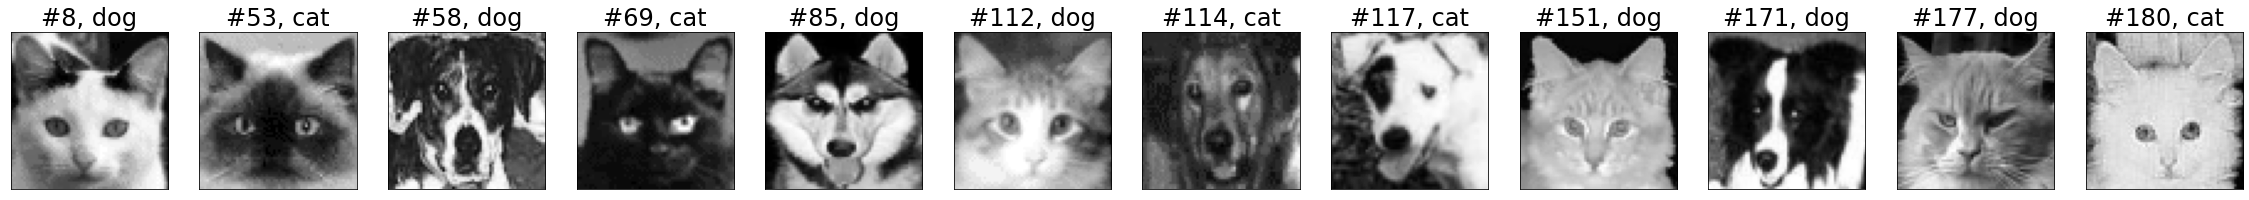

In [8]:
def find_mislabeling(mislabeled, consistency_threshold=1, verbose=False, plotting=False):
    names=['cat', 'dog']
    occurences = {}
    combined = np.array([])

    for key in mislabeled.keys():
        occurences[key] = np.bincount(mislabeled[key])
        tmp = np.array(mislabeled[key])
        if len(tmp)==0:
            continue
        else:
            combined = np.append(combined, np.unique(tmp[occurences[key][tmp]>consistency_threshold])).astype(int)

    consistent_mislabels = np.argwhere(np.bincount(combined)>2).flatten()   # >2 to make it all three models
    
    if verbose:
        print('consistently mislabeled indices: ', consistent_mislabels)
    
    if plotting and len(consistent_mislabels)!=0:
        # Visualize mislabeled images
        fig, axs = plt.subplots(nrows=1, ncols=len(consistent_mislabels), figsize=(40,8))
        for i, label in enumerate(consistent_mislabels):
            axs[i].imshow(catsndogs.iloc[label].to_numpy().reshape((64,64), order='F'), cmap='gray')
            axs[i].get_xaxis().set_visible(False)
            axs[i].get_yaxis().set_visible(False)
            axs[i].set_title(f'#{label}, {names[labels.values[label,0]]}', fontsize=24)

    # Are the errors balanced?
    if verbose:
        print(f'Fraction of dogs in the set of images mislabeled more than {consistency_threshold} times by one or more model:\n{np.sum(labels.values[consistent_mislabels,0])/len(labels.values[consistent_mislabels,0])}')
    
    return consistent_mislabels


consistent_mislabels = find_mislabeling(test_mislab, verbose=True, plotting=True)

For kNN with k=5 we get 0.75, logistic regression we get 0.74, and random forest gives 0.71. This is better than random, but not particularly good.

Some images are quite consistently mislabeled. If we consider being mislabeled by all three classifiers more than twice out of 20 repetitions consistent, there are about 18 consistently mislabeled images. (9/18 mislabeled images, some dogs that have cat-like ears) However, despite 80/20 train/test split no images seem to be close to being mislabeled near 80% of the time, the most is around 20-50%     --(???)--

The errors are imbalanced, out of the consistently mislabeled images about 80% were labeled as "dog", although some where mislabeled. 

## 1b (10p)
 - Identify the most important pixels for classification - are these easy to identify or is there uncertainty in the selection of important features? Compare at least 3 methods for selecting/identifying features. Note, does not need to be the same methods as in 1a. Can you think of a way to improve on the stability of selection/identification?

 - Can you explain why these pixels are selected/are deemed important?

 - Do the identified predictive features differ between the classification methods?

In [9]:
# Logisticregression CV
# Train model on full dataset - get coef to make correct model

x = catsndogs.to_numpy()
y = labels.values[:,0]

lrCV = LogisticRegressionCV(Cs=np.logspace(-4, 4, 50), multi_class='ovr', solver='liblinear', penalty='l1', intercept_scaling=1000, scoring='accuracy').fit(x, y)

#lrCV = LogisticRegressionCV(Cs=hp, cv=n_folds, scoring='f1', penalty='l1', multi_class='ovr', solver='liblinear', intercept_scaling=10000).fit(x, y)

print(lrCV.C_)

[0.5689866]


ft. imp. bootstrap 0


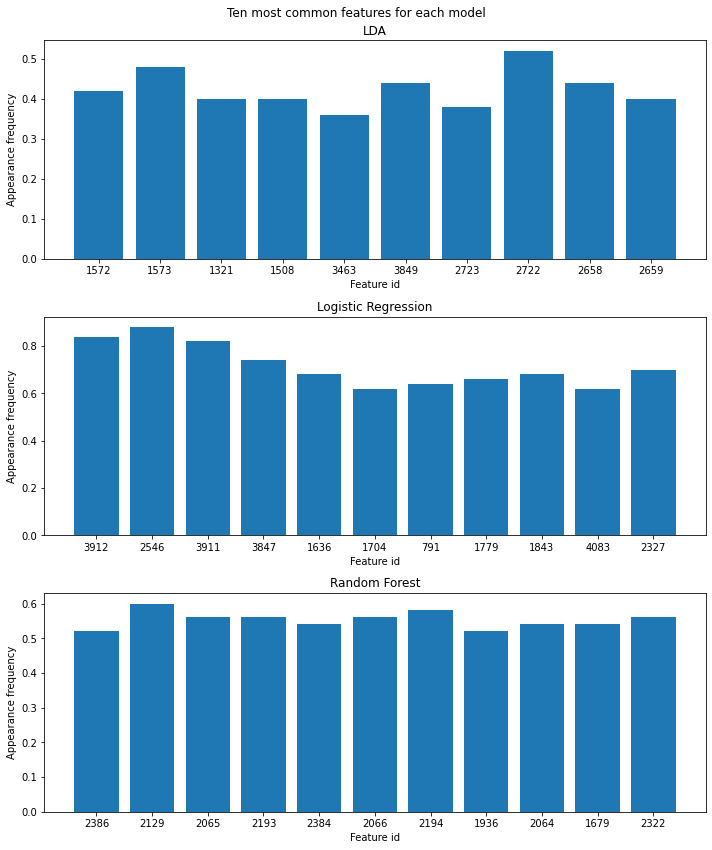

In [12]:
# Feature importance coefficients
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import collections

def get_f_imp(x,y,repetitions=50, verbose=False):

    if type(x)==pd.DataFrame:
        x = x.to_numpy()
        if verbose:
            print(f'/get_f_imp/: x, converted to np')

    if type(y)==pd.DataFrame:
        y = y.to_numpy().flatten()
        if verbose:
            print(f'/get_f_imp/: y, converted to np')
    
    lr = LogisticRegression(C=lrCV.C_[0], multi_class='ovr', solver='liblinear', penalty='l1')
    lr_coefs = np.empty(shape=(repetitions, len(x[0])))

    rf = RandomForestClassifier()
    rf_coefs = np.empty(shape=(repetitions, len(x[0])))

    lda = LinearDiscriminantAnalysis()
    lda_coefs = np.empty(shape=(repetitions, len(x[0])))

    for i in range(repetitions):
        if i % 100 == 0:
            print(f'ft. imp. bootstrap {i}')
        # Choose n random points
        idxs = np.random.choice(len(y), size=len(y), replace=True)
        x_tmp = x[idxs]
        y_tmp = y[idxs]

        # Fit model to points
        lr.fit(x_tmp, y_tmp)
        rf.fit(x_tmp, y_tmp)
        lda.fit(x_tmp, y_tmp)

        # Get coefficients to see most important features
        lr_coefs[i,:] = lr.coef_[0]
        rf_coefs[i,:] = rf.feature_importances_
        lda_coefs[i,:] = lda.coef_[0]

    lda_coefs_mean = np.mean(lda_coefs, axis=0)
    lr_coefs_mean = np.mean(lr_coefs, axis=0)
    rf_coefs_mean = np.mean(rf_coefs, axis=0)

    # Find how many times a feature is top 100:
    # Sort coefficients by size
    top_lda = np.flip(np.argsort(np.abs(lda_coefs), axis=1))[:,:100]
    top_lr = np.flip(np.argsort(np.abs(lr_coefs), axis=1))[:,:100]
    top_rf = np.flip(np.argsort(np.abs(rf_coefs), axis=1))[:,:100]

    cnt_lda = collections.Counter(top_lda.flatten())
    cnt_lr = collections.Counter(top_lr.flatten())
    cnt_rf = collections.Counter(top_rf.flatten())

    top_lda_ids = np.where( list(cnt_lda.values()) >= np.flip(np.sort(list(cnt_lda.values())))[9])[0]
    top_lr_ids = np.where( list(cnt_lr.values()) >= np.flip(np.sort(list(cnt_lr.values())))[9])[0]
    top_rf_ids = np.where( list(cnt_rf.values()) >= np.flip(np.sort(list(cnt_rf.values())))[9])[0]


    fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(10, 12))
    axs[0].bar(np.array([str(it) for it in np.array(list(cnt_lda.keys()))])[top_lda_ids], np.array(list(cnt_lda.values()))[top_lda_ids]/repetitions)
    axs[0].set_title('LDA')
    axs[1].bar(np.array([str(it) for it in np.array(list(cnt_lr.keys()))])[top_lr_ids], np.array(list(cnt_lr.values()))[top_lr_ids]/repetitions)
    axs[1].set_title('Logistic Regression')
    axs[2].bar(np.array([str(it) for it in np.array(list(cnt_rf.keys()))])[top_rf_ids], np.array(list(cnt_rf.values()))[top_rf_ids]/repetitions)
    axs[2].set_title('Random Forest')

    for ax in axs:
        ax.set_ylabel('Appearance frequency')
        ax.set_xlabel('Feature id')

    fig.suptitle('Ten most common features for each model')
    fig.tight_layout()
    return lda_coefs_mean, lr_coefs_mean, rf_coefs_mean


lda_coefs_mean, lr_coefs_mean, rf_coefs_mean = get_f_imp(catsndogs,labels,repetitions=50)#500)

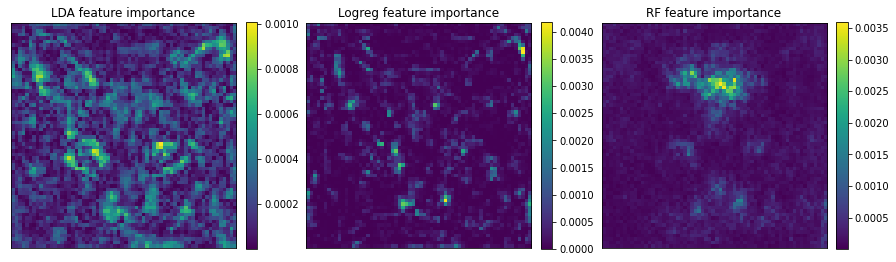

In [13]:
from matplotlib.colors import LogNorm

def plot_f_imp(lda_coefs_mean, lr_coefs_mean, rf_coefs_mean):
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

    im_size = int(np.sqrt(len(lda_coefs_mean)))

    lda_importance = lda_coefs_mean.reshape((im_size,im_size), order='F')
    im0 = axs[0].imshow(np.abs(lda_importance))
    axs[0].set_title('LDA feature importance')
    fig.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)

    lr_importance = lr_coefs_mean.reshape((im_size,im_size), order='F')
    im1 = axs[1].imshow(np.abs(lr_importance))
    axs[1].set_title("Logreg feature importance")

    fig.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

    rf_importance = rf_coefs_mean.reshape((im_size,im_size), order='F')
    im2 = axs[2].imshow(rf_importance)
    axs[2].set_title('RF feature importance')
    fig.colorbar(im2, ax=axs[2], fraction=0.046, pad=0.04)

    for ax in axs:
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

plot_f_imp(lda_coefs_mean, lr_coefs_mean, rf_coefs_mean)

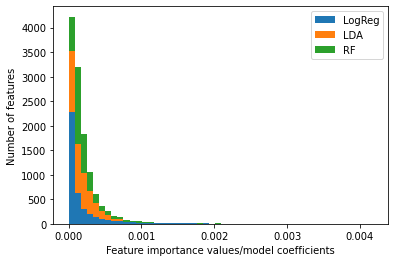

In [14]:
# Histograms
fig, ax = plt.subplots(nrows=1, ncols=1)

hist_data = np.stack([np.abs(lr_coefs_mean), np.abs(lda_coefs_mean), rf_coefs_mean], axis=-1)
ax.hist(hist_data, bins=50, histtype='bar', stacked=True, fill=True)
#ax.set_yscale('log')
ax.set_ylabel('Number of features')
ax.set_xlabel('Feature importance values/model coefficients')
plt.legend(['LogReg', 'LDA', 'RF'])
plt.show()

## 1c (10p)
Cluster the data set. Do the clusters agree with the class labels? Does changing the number of clusters have an impact on the overlap with the class labels?

What characteristics of the data does the clustering pick up?

Please think carefully about how you go about this question - how do you choose your input (e.g. do you perform preprocessing or not) to the clustering algorithm? what method and settings? Is it as clear cut how to make these choices if you didn't know the labels?

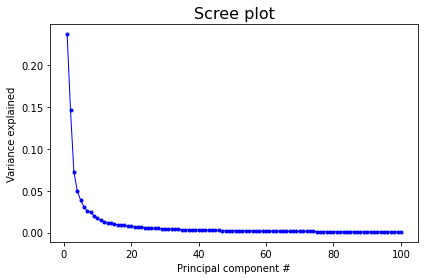

In [15]:
from sklearn.decomposition import PCA

pca = PCA(n_components=100)
p_comps = pca.fit_transform(catsndogs)

principal_df = pd.DataFrame(p_comps)
combined_df = pd.concat([ labels['x'], principal_df], axis=1)

plt.plot(np.arange(pca.n_components_)+1, pca.explained_variance_ratio_, marker='o', markerfacecolor='blue', markersize=3, color='blue', linewidth=1)
plt.title('Scree plot',fontsize=16)
plt.xlabel('Principal component #')
plt.ylabel('Variance explained')
plt.tight_layout()
plt.show()


     x            0            1            2            3            4  \
0    0 -2731.106062  1403.814591   329.445998   767.707128  1302.724190   
1    0   637.649951 -1206.936306  -796.214295 -1410.718667   336.025902   
2    1 -1371.674206 -1438.013968  -289.873204   -85.099626  -634.403799   
3    1 -3458.994358  -771.788478  1399.494883  1299.372230  -956.657650   
4    1   952.879710 -1635.884918   211.876922  -870.592286  -504.636243   
..  ..          ...          ...          ...          ...          ...   
193  0 -1534.304974 -1231.017980 -1753.035020   221.652396  1382.992513   
194  1   571.834881  -863.798556  -972.476324  -494.472433   964.198976   
195  1  2067.930014  -494.753661  2394.640099 -1029.886230   216.210865   
196  0    76.741473  1555.343506  -487.795214   564.812737    -3.030353   
197  0  1987.318373   825.031138  -248.817787  1644.325362 -1805.290821   

               5            6            7           8  ...          90  \
0    -691.424919   985.8

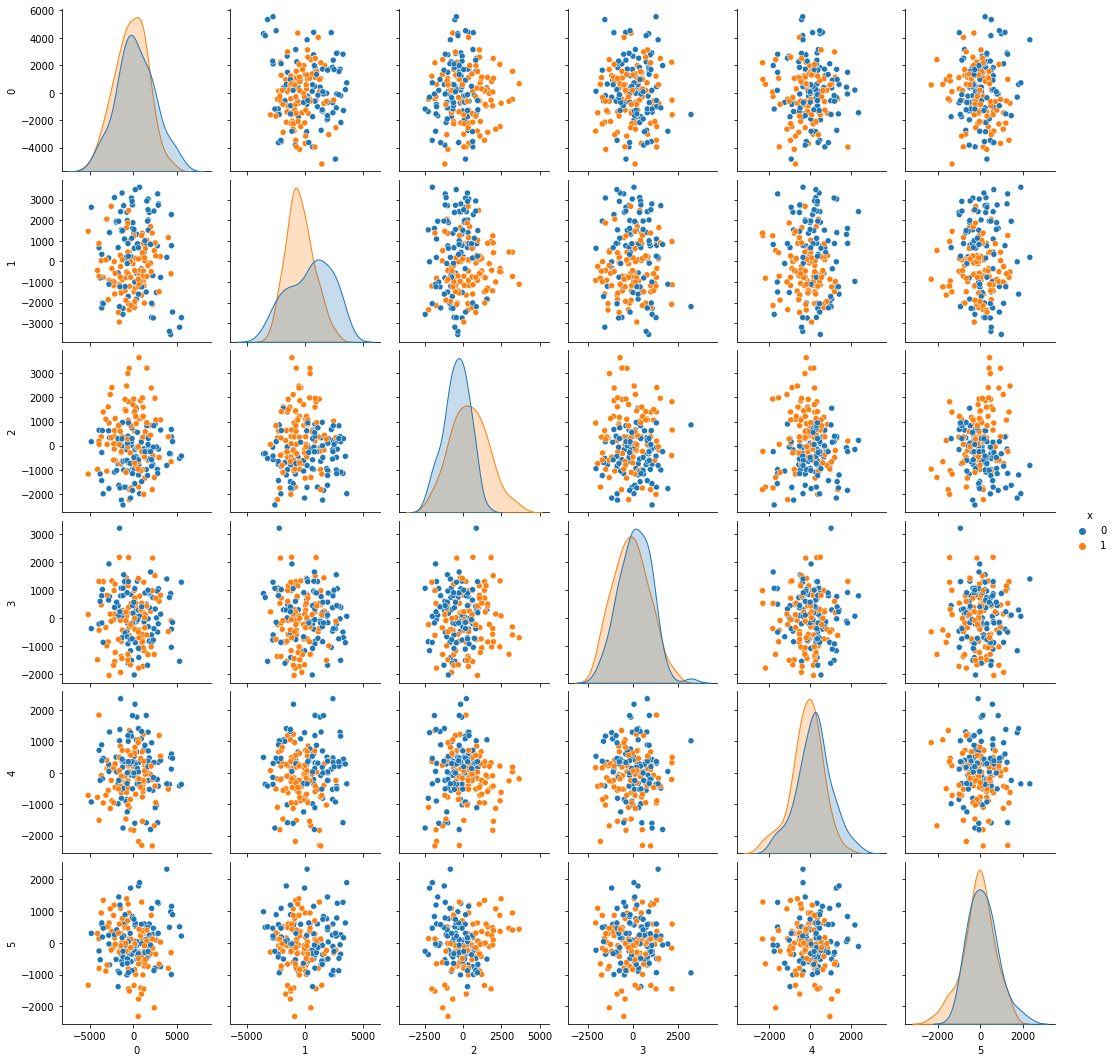

In [17]:
import seaborn as sns
print(combined_df.loc[:, :pca.n_components_-1])
sns.pairplot(combined_df.loc[:, :5], hue='x')

Text(33.0, 0.5, 'True label')

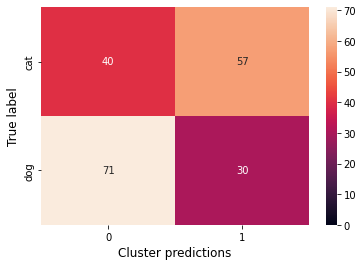

In [18]:
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize

km = KMeans(n_clusters=2).fit(normalize(catsndogs))

conf_mat = confusion_matrix(labels.values, km.labels_)

s = sns.heatmap(conf_mat, annot=True, vmin=0, yticklabels=['cat', 'dog'])
s.set_xlabel('Cluster predictions', fontsize=12)
s.set_ylabel('True label', fontsize=12)


Idéer för att se hur väl kluster överensstämmer:
 - För bara n=2 funkar confusion matrix eller nån manuell beräkning som jag har för mig att jag gjort tidigare
 - Göra bar plots som i project 2? dvs Anta att majoriteten i det predictade klustret är "korrekt" och resten blir overlap(?) Blir ju typ vad de frågar efter, men känns inte så proffsigt/korrekt liksom. Går typ att kika på med skeva (2x3/4) confusion matrix som ovan men inte heller dunder

## 1d (10p)
Cluster the cat and dog data sets separately. How many clusters are there in the cat data? what about the dogs?

Are these the same or differ? Can you think of why? What characterstics of the data do the respective clusterings represent?

In [19]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

def score_n_clusters(data, max_n, reps):
    
    n_range = range(2,max_n)

    sil = np.empty(shape=(max_n-2, reps))
    ch = np.empty(shape=(max_n-2, reps))
    db = np.empty(shape=(max_n-2, reps))

    for n in n_range:
        for i in range(reps):
            km = KMeans(n_clusters=n).fit(data)
            sil[n-2,i] = silhouette_score(data, km.labels_)
            ch[n-2,i] = calinski_harabasz_score(data, km.labels_)
            db[n-2,i] = davies_bouldin_score(data, km.labels_)
        
    sil = sil/np.max(sil)
    ch = ch/np.max(ch)
    db = db/np.max(db)


    fig = plt.figure()
    ax = fig.gca()

    ax.plot(n_range, np.mean(sil, axis=1), label='Silhoutte width')
    ax.fill_between(n_range, np.mean(sil, axis=1)+np.std(sil, axis=1), np.mean(sil, axis=1)-np.std(sil, axis=1), alpha=0.3)

    ax.plot(n_range, np.mean(ch, axis=1), label='Calinski Harabasz')
    ax.fill_between(n_range, np.mean(ch, axis=1)+np.std(ch, axis=1), np.mean(ch, axis=1)-np.std(ch, axis=1), alpha=0.3)

    ax.plot(n_range, np.mean(db, axis=1), label='Davies Bouldin')
    ax.fill_between(n_range, np.mean(db, axis=1)+np.std(db, axis=1), np.mean(db, axis=1)-np.std(db, axis=1), alpha=0.3)

    ax.legend(loc='lower left')

    ax.set_ylabel('Scores scaled to be max 1')
    ax.set_xlabel('Amount of clusters')
    ax.set_xticks(range(2,max_n,2))

    # Blir rätt olika varje gång, kanske average med errorbars
    plt.show()

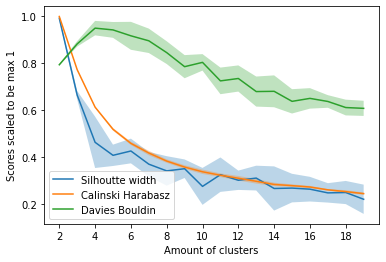

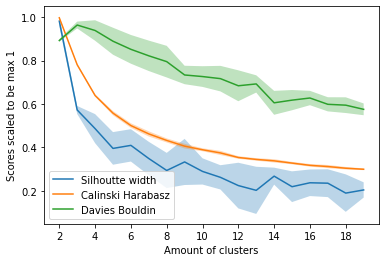

In [20]:
cats = catsndogs[labels.values==0]
dogs = catsndogs[labels.values==1]

max_n = 20
n_range = range(2,max_n)
n_reps = 10

score_n_clusters(normalize(cats), max_n, n_reps)
score_n_clusters(normalize(dogs), max_n, n_reps)



## 1e (10p)
Use your chosen number of clusters for the cats and dogs (if you selected 1 cluster, use 2 for this task). Rerun task 1a and 1b on the cats data with the cat cluster labels as classes. Rerun tasks 1a and 1b on the dogs data with the dog cluster labels as classes.

Are similar sets of features important for these tasks as in task 1b? Are similar sets of features important for the cat cluster predictions and the dog cluster predictions? Explain why/why not?

In [48]:
km_c = KMeans(n_clusters=2).fit(normalize(cats))
cat_labels = km_c.labels_

cat_acc, cat_mislab = analyze_separation(cats, km_c.labels_, repetitions=20)

km_d = KMeans(n_clusters=2).fit(normalize(dogs))
dog_labels = km_d.labels_

dog_acc, dog_mislab = analyze_separation(dogs, km_d.labels_, repetitions=20)

yes
{'knn': 0.9175000000000001, 'lr': 0.9825000000000003, 'rf': 0.925}
yes
{'knn': 0.907142857142857, 'lr': 0.9714285714285713, 'rf': 0.9285714285714286}


### Examples from each cluster, cats and dogs

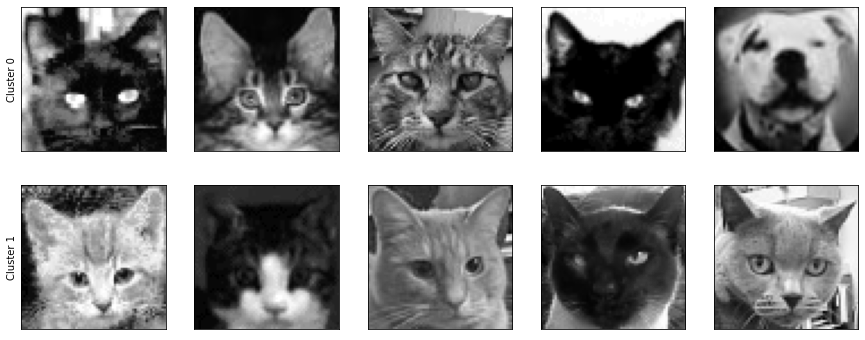

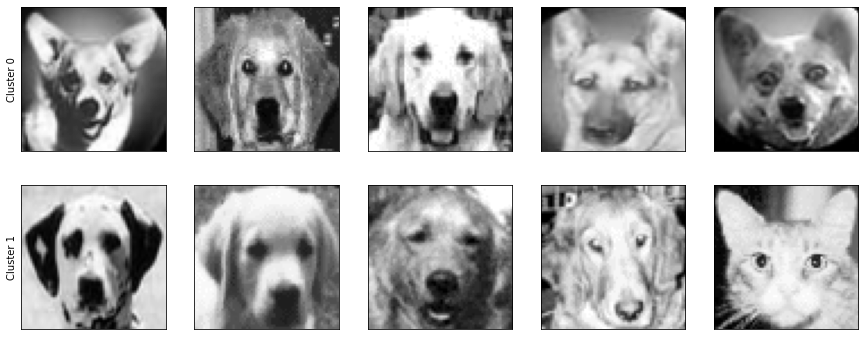

In [49]:
# Showing some examples from each cluster
# Kan vara så att km modellen behöver göras om om man kör denna igen
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(15,6))
idxs_1 = np.argwhere(km.labels_==0).flatten()
idxs_2 = np.argwhere(km.labels_==1).flatten()

for row in range(2):
    for col in range(5):
        if row==0:
            axs[row,col].imshow(cats.iloc[idxs_1[col]].to_numpy().reshape((64,64), order='F'), cmap='gray')
        elif row==1:
            axs[row,col].imshow(cats.iloc[idxs_2[col]].to_numpy().reshape((64,64), order='F'), cmap='gray')
        
        #axs[row,col].get_xaxis().set_visible(False)
        axs[row,col].set_xticklabels([])
        axs[row,col].set_xticks([])
        axs[row,col].set_yticklabels([])
        axs[row,col].set_yticks([])

axs[0,0].set_ylabel(f'Cluster {0}')
axs[1,0].set_ylabel(f'Cluster {1}')

fig.set_facecolor('white')

plt.show()

fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(15,6))
idxs_1 = np.argwhere(km.labels_==0).flatten()
idxs_2 = np.argwhere(km.labels_==1).flatten()

for row in range(2):
    for col in range(5):
        if row==0:
            axs[row,col].imshow(dogs.iloc[idxs_1[col+5]].to_numpy().reshape((64,64), order='F'), cmap='gray')
        elif row==1:
            axs[row,col].imshow(dogs.iloc[idxs_2[col+5]].to_numpy().reshape((64,64), order='F'), cmap='gray')
        
        #axs[row,col].get_xaxis().set_visible(False)
        axs[row,col].set_xticklabels([])
        axs[row,col].set_xticks([])
        axs[row,col].set_yticklabels([])
        axs[row,col].set_yticks([])

axs[0,0].set_ylabel(f'Cluster {0}')
axs[1,0].set_ylabel(f'Cluster {1}')

fig.set_facecolor('white')

### Vet inte om detta ska med eller om man ska gå rakt på b)?

In [50]:
#occurences = {}
#combined = np.array([])
#consistency_threshold = 1

#for key in mislab.keys():
#    occurences[key] = np.bincount(mislab[key])
#    tmp = np.array(mislab[key])
#    combined = np.append(combined, np.unique(tmp[occurences[key][tmp]>consistency_threshold])).astype(int)

#consistent_mislabels = np.argwhere(np.bincount(combined)>2).flatten()   # >2 to make it all three models
#print('consistently mislabeled indices: ', consistent_mislabels)

# Visualize mislab images
#fig, axs = plt.subplots(nrows=1, ncols=len(consistent_mislabels), figsize=(40,8))
#for i, label in enumerate(consistent_mislabels):
#    axs[i].imshow(catsndogs.iloc[label].to_numpy().reshape((64,64), order='F'), cmap='gray')
#    axs[i].get_xaxis().set_visible(False)
#    axs[i].get_yaxis().set_visible(False)
#    axs[i].set_title(f'#{label}, {names[labels.values[label,0]]}', fontsize=24)

# Are the errors balanced?


### b) part

#### cats

In [51]:

lrCV = LogisticRegressionCV(Cs=np.logspace(-4, 4, 30), multi_class='ovr', solver='liblinear', penalty='l1', intercept_scaling=1000, scoring='accuracy').fit(normalize(cats), cat_labels)

print(lrCV.C_)

[32.90344562]


In [52]:
x = normalize(cats.to_numpy())
y = cat_labels

repetitions = 50    # TODO Köra dessa med minst 500

lr = LogisticRegression(C=lrCV.C_[0], multi_class='ovr', solver='liblinear', penalty='l1')
lr_coefs = np.empty(shape=(repetitions, len(x[0])))

rf = RandomForestClassifier()
rf_coefs = np.empty(shape=(repetitions, len(x[0])))

lda = LinearDiscriminantAnalysis()
lda_coefs = np.empty(shape=(repetitions, len(x[0])))

for i in range(repetitions):
    if i % 50 == 0:
        print(f'bootstrap {i}')
    # Choose n random points
    idxs = np.random.choice(len(y), size=len(y), replace=True)
    x_tmp = x[idxs]
    y_tmp = y[idxs]

    # Fit model to points
    lr.fit(x_tmp, y_tmp)
    rf.fit(x_tmp, y_tmp)
    lda.fit(x_tmp, y_tmp)

    # Get coefficients to see most important features
    lr_coefs[i,:] = lr.coef_[0]
    rf_coefs[i,:] = rf.feature_importances_
    lda_coefs[i,:] = lda.coef_[0]

lda_coefs_mean = np.mean(lda_coefs, axis=0)
lr_coefs_mean = np.mean(lr_coefs, axis=0)
rf_coefs_mean = np.mean(rf_coefs, axis=0)

bootstrap 0


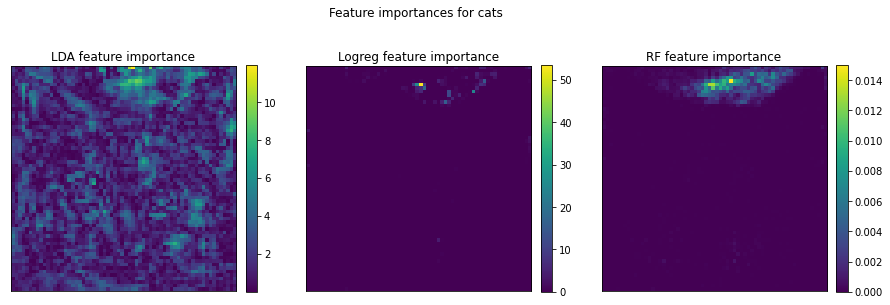

In [53]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

lda_importance = lda_coefs_mean.reshape((64,64), order='F')
im0 = axs[0].imshow(np.abs(lda_importance))
axs[0].set_title('LDA feature importance')
fig.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)

lr_importance = lr_coefs_mean.reshape((64,64), order='F')
im1 = axs[1].imshow(np.abs(lr_importance))
axs[1].set_title("Logreg feature importance")

fig.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

rf_importance = rf_coefs_mean.reshape((64,64), order='F')
im2 = axs[2].imshow(rf_importance)
axs[2].set_title('RF feature importance')
fig.colorbar(im2, ax=axs[2], fraction=0.046, pad=0.04)

for ax in axs:
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

fig.suptitle('Feature importances for cats')
plt.show()

#### dogs

In [54]:
lrCV = LogisticRegressionCV(Cs=np.logspace(-4, 4, 30), multi_class='ovr', solver='liblinear', penalty='l1', intercept_scaling=1000, scoring='accuracy').fit(dogs, dog_labels)

print(lrCV.C_)

[0.20433597]


In [55]:
x = normalize(dogs.to_numpy())
y = dog_labels

repetitions = 50    #TODO Köra dessa med minst 500

lr = LogisticRegression(C=lrCV.C_[0], multi_class='ovr', solver='liblinear', penalty='l1')
lr_coefs = np.empty(shape=(repetitions, len(x[0])))

rf = RandomForestClassifier()
rf_coefs = np.empty(shape=(repetitions, len(x[0])))

lda = LinearDiscriminantAnalysis()
lda_coefs = np.empty(shape=(repetitions, len(x[0])))

for i in range(repetitions):
    if i % 50 == 0:
        print(f'bootstrap {i}')
    # Choose n random points
    idxs = np.random.choice(len(y), size=len(y), replace=True)
    x_tmp = x[idxs]
    y_tmp = y[idxs]

    # Fit model to points
    lr.fit(x_tmp, y_tmp)
    rf.fit(x_tmp, y_tmp)
    lda.fit(x_tmp, y_tmp)

    # Get coefficients to see most important features
    lr_coefs[i,:] = lr.coef_[0]
    rf_coefs[i,:] = rf.feature_importances_
    lda_coefs[i,:] = lda.coef_[0]

lda_coefs_mean = np.mean(lda_coefs, axis=0)
lr_coefs_mean = np.mean(lr_coefs, axis=0)
rf_coefs_mean = np.mean(rf_coefs, axis=0)

bootstrap 0


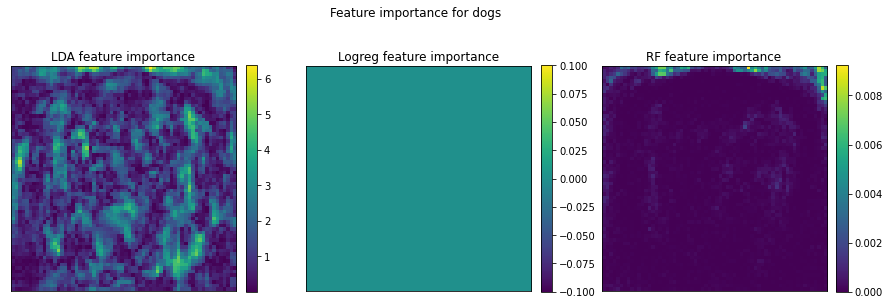

In [56]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

lda_importance = lda_coefs_mean.reshape((64,64), order='F')
im0 = axs[0].imshow(np.abs(lda_importance))
axs[0].set_title('LDA feature importance')
fig.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)

lr_importance = lr_coefs_mean.reshape((64,64), order='F')
im1 = axs[1].imshow(np.abs(lr_importance))
axs[1].set_title("Logreg feature importance")

fig.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

rf_importance = rf_coefs_mean.reshape((64,64), order='F')
im2 = axs[2].imshow(rf_importance)
axs[2].set_title('RF feature importance')
fig.colorbar(im2, ax=axs[2], fraction=0.046, pad=0.04)

for ax in axs:
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

fig.suptitle('Feature importance for dogs')
plt.show()

## 1f (10p)

Cluster only a subset of the cat images leaving the rest of the cat images together with the dogs as a separate test set.

On the clustered cat data subset, build a classifier for the cluster labels.

Apply this to predict the labels on the testdata of cat images and dog images - does learning cat cluster labels identify characteristics in the data that separate cats from dogs?

In [274]:
# split into set of cats for training, and the rest for testing
cat_only_ids = cats.index.to_list()
tr_c_ids = np.random.choice(cats.index.to_list(), size=70, replace=False)
test_c_ids =  catsndogs.index.to_list()
test_c_ids = np.delete(test_c_ids, tr_c_ids)

tr_c_set = catsndogs.iloc[tr_c_ids]
tr_c_labels = labels.iloc[tr_c_ids].to_numpy().flatten()
test_c_set = catsndogs.iloc[test_c_ids]
test_c_labels = labels.iloc[test_c_ids].to_numpy().flatten()

rf_c = RandomForestClassifier()
km_acc = 0
rf_acc = 0
n_reps = 10

km_dog_frac_l, km_dog_frac_s, rf_dog_frac_l, rf_dog_frac_s, = 0,0,0,0
for _ in range(n_reps):
    # Cluster on training data
    km_c = KMeans(n_clusters=2).fit(tr_c_set)
    test = tr_c_set.iloc[km_c.labels_==np.argmin(np.bincount(km_c.labels_))]
    print(f'Training split: {np.bincount(km_c.labels_)}')
    #print(f'Pixel means per cluster: {np.mean(tr_c_set.iloc[km_c.labels_==np.argmin(np.bincount(km_c.labels_))].mean())}, {np.mean(tr_c_set.iloc[km_c.labels_==np.argmax(np.bincount(km_c.labels_))].mean())}')

    # Build classifier for cluster labels (on training data)
    rf_c.fit(tr_c_set, km_c.labels_)

    # Does learning the cat cluster label help separate cats from dogs?
    km_preds = km_c.predict(test_c_set)
    rf_preds = rf_c.predict(test_c_set)

    km_acc += np.max([np.sum([km_preds==test_c_labels])/len(test_c_labels), np.sum([km_preds!=test_c_labels])/len(test_c_labels)])
    rf_acc += np.max([np.sum([rf_preds==test_c_labels])/len(test_c_labels), np.sum([rf_preds!=test_c_labels])/len(test_c_labels)])

    km_dog_frac_l += test_c_labels[km_preds==np.argmax(np.bincount(km_preds))].mean()/n_reps
    km_dog_frac_s += test_c_labels[km_preds==np.argmin(np.bincount(km_preds))].mean()/n_reps
    rf_dog_frac_l += test_c_labels[rf_preds==np.argmax(np.bincount(rf_preds))].mean()/n_reps
    rf_dog_frac_s += test_c_labels[rf_preds==np.argmin(np.bincount(rf_preds))].mean()/n_reps

print(f'Fraction of dogs in test set: {np.mean(test_c_labels)}')
print(f'Fraction of dogs in kmeans clusters: {km_dog_frac_l}, {km_dog_frac_s}. [large,small]')
print(f'Fraction of dogs in rf classes: {rf_dog_frac_l}, {rf_dog_frac_s}. [large,small]')
    # ^ Checks how many in the small/large cluster are dogs - compare to actual fraction of dog imaes


print(km_acc/n_reps)
print(rf_acc/n_reps)


# Maybe do something else than accuracy to explain "separation"

Training split: [43 27]
Training split: [26 44]
Training split: [26 44]
Training split: [44 26]
Training split: [44 26]
Training split: [26 44]
Training split: [26 44]
Training split: [43 27]
Training split: [26 44]
Training split: [44 26]
Fraction of dogs in test set: 0.7890625
Fraction of dogs in kmeans clusters: 0.7920819490586932, 0.7831168831168831. [large,small]
Fraction of dogs in rf classes: 0.7988942869549996, 0.7560670877244848. [large,small]
0.6015625
0.66015625


fraction of dogs:  0.7890625
[ True  True False  True False False  True  True False  True  True  True
  True False  True  True  True  True  True  True  True  True  True False
  True  True  True  True  True False False False  True  True False  True
 False  True  True False  True False False  True False  True False False
  True  True  True False  True  True  True False  True False  True  True
  True False  True False  True False  True  True False  True  True  True
  True  True  True  True False  True False  True False  True  True False
 False False  True False False False False False False  True False False
  True  True  True  True  True  True False  True  True  True  True  True
  True  True False  True  True False False  True False  True  True  True
  True False  True  True False  True False False]
[1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 0 1 0 0 1 0 1 1 1 1 1
 1 1 0 1 1 1 1 1 1 1 1 0 1 0 0 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 1 1 0 0 1 1 0
 1 1 1 1 1 1 1]
0.6328125


Text(33.0, 0.5, 'True label')

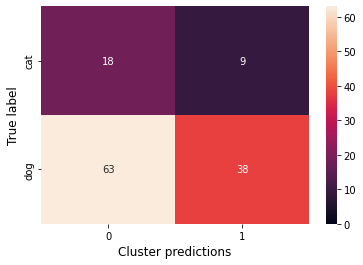

In [256]:
print('fraction of dogs: ',np.mean(test_c_labels))
print(km_preds==0)
print(test_c_labels[km_preds==0])
print(np.max([np.mean(km_preds), np.mean(np.ones(shape=km_preds.shape)-km_preds)]))
c_mat = confusion_matrix(test_c_labels, km_preds)
s = sns.heatmap(c_mat, annot=True, vmin=0, yticklabels=['cat', 'dog'])
s.set_xlabel('Cluster predictions', fontsize=12)
s.set_ylabel('True label', fontsize=12)

# Question 2 (60p)


We will continue to work with the Cats and Dogs data set but now use simulations to investigate how feature selection and classification can be affected by various kinds of noise contamination. Here the focus is on cats vs dog prediction.

Since the tasks below are simulation based you will need to repeat the task for multiple runs and also compare to the noise free results for reference.

## 2a (10p)


Add random noise to a randomly selected subset of images. That is, change the pixel value from the original to something else but still in the [0,256] range and in such a fashion that you control how much noise are added (how much you change the original pixel value).

Vary the noise level (at least 2 levels) and the number of affected images (at least 3 levels). How does a subset of noisy images affect the overall classification performance?

Are the noisy images over-represented as those that are misclassified (training error and test error)?

Noise std: 5, on 25 images
{'knn': 0.7434999999999999, 'lr': 0.7345000000000002, 'rf': 0.733}
Frequency of noisy images being mislabeled (test): 0.16666666666666666
Frequency of noisy images: 0.12626262626262627

Noise std: 5, on 99 images
{'knn': 0.7615000000000002, 'lr': 0.7455, 'rf': 0.7485000000000003}
Frequency of noisy images being mislabeled (test): 0.6060606060606061
Frequency of noisy images: 0.5

Noise std: 5, on 198 images
{'knn': 0.77, 'lr': 0.758, 'rf': 0.763}
Frequency of noisy images being mislabeled (test): 1.0
Frequency of noisy images: 1.0

Noise std: 50, on 25 images
{'knn': 0.7570000000000002, 'lr': 0.751, 'rf': 0.775}
Frequency of noisy images being mislabeled (test): 0.13513513513513514
Frequency of noisy images: 0.12626262626262627

Noise std: 50, on 99 images
{'knn': 0.7485000000000002, 'lr': 0.7539999999999999, 'rf': 0.7440000000000001}
Frequency of noisy images being mislabeled (test): 0.5
Frequency of noisy images: 0.5

Noise std: 50, on 198 images
{'knn': 0.

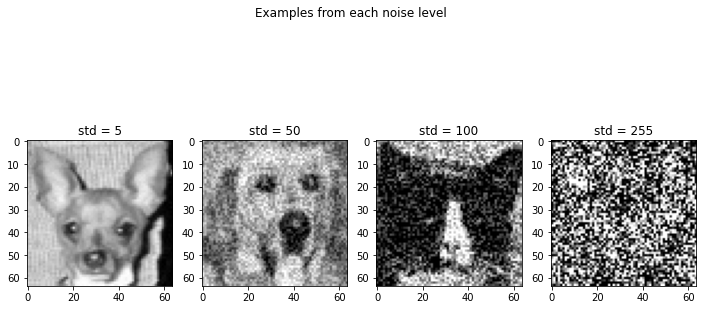

In [60]:
from copy import deepcopy

noise_levels = [5, 50, 100, 255]
ns_affected = [25, 99, 198]

noisy_accs = np.empty(shape=(len(noise_levels), len(ns_affected), 3))
n_freq = np.empty(shape=(len(noise_levels), len(ns_affected)))
nm_freq_t = np.empty(shape=(len(noise_levels), len(ns_affected)))
nm_freq_tr = np.empty(shape=(len(noise_levels), len(ns_affected)))

fig, ax = plt.subplots(nrows=1, ncols=len(noise_levels), figsize=(12,6))

for i, noise_lv in enumerate(noise_levels):
    for j, n in enumerate(ns_affected):
        print(f'Noise std: {noise_lv}, on {n} images')
        # Add noise according to level and n affected
        noisy_ids = np.random.choice(catsndogs.index, size=n, replace=False)
        noisy_ims = deepcopy(catsndogs)
        #noise = np.random.normal(loc=0, scale=noise_lv, size=4096)
        noise = np.random.uniform(low=-noise_lv, high=noise_lv, size=4096)
        noisy_ims.iloc[noisy_ids] += noise
        noisy_ims[noisy_ims > 255] = 255
        noisy_ims[noisy_ims < 0] = 0
        
        if n == ns_affected[0]:
            ax[i].imshow(deepcopy(noisy_ims.iloc[noisy_ids[0]]).to_numpy().reshape((64,64), order='F'), cmap='gray')
            ax[i].set_title(f'std = {noise_lv}')

        noisy_t_acc, noisy_tr_acc, noisy_t_mislab, noisy_tr_mislab = analyze_separation(noisy_ims, labels, repetitions=50, return_train=True)
        for k, key in enumerate(noisy_t_acc.keys()):

            noisy_accs[i,j,k] = noisy_t_acc[key]  # accuracy for classifier
            #noisy_mislabs_avg = noisy_mislab[key]    # ids for every mislabeled image by classifier

        cons_t_mislab = find_mislabeling(noisy_t_mislab, consistency_threshold=1)
        cons_tr_mislab = find_mislabeling(noisy_tr_mislab, consistency_threshold=1)
        
        noisy_and_mislabeled_t = np.intersect1d(cons_t_mislab, noisy_ids)
        noisy_and_mislabeled_tr = np.intersect1d(cons_tr_mislab, noisy_ids)
        
        if len(cons_t_mislab)!=0:
            nm_freq_t[i,j] = len(noisy_and_mislabeled_t)/len(cons_t_mislab)
        else:
            nm_freq_t[i,j] = np.nan

        if len(cons_tr_mislab)!=0:
            nm_freq_tr[i,j] = len(noisy_and_mislabeled_tr)/len(cons_tr_mislab)
        else:
            nm_freq_tr[i,j] = np.nan
        print(f'Frequency of noisy images being mislabeled (test): {nm_freq_t[i,j]}')
        n_freq[i,j] = n/198
        print(f'Frequency of noisy images: {n_freq[i,j]}\n')
        # Need to find if the noisy images are over-represented in mislabeled
        # Save frequency of noisy in mislab and compare to n_affected
fig.suptitle('Examples from each noise level')
plt.show()

Not sure whats going on [0.7435 0.7345 0.733 ], shape=(3,)
Mean test accuracy:
[[0.737      0.75183333 0.76366667]
 [0.761      0.74883333 0.74366667]
 [0.75316667 0.7325     0.7515    ]
 [0.76266667 0.732      0.74966667]]
------------------------------------------------------------
[[0.16666667 0.60606061 1.        ]
 [0.13513514 0.5        1.        ]
 [0.09677419 0.42857143 1.        ]
 [0.09375    0.45238095 1.        ]]
nfreq: [0.12626263 0.5        1.        ]


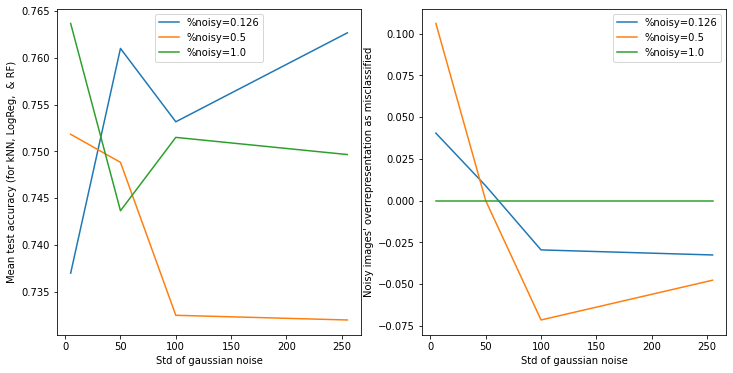

In [61]:
print(f'Not sure whats going on {noisy_accs[0,0,:]}, shape={noisy_accs[0,0,:].shape}')
print(f'Mean test accuracy:\n{np.mean(noisy_accs, axis=2)}')
print('--------------------'*3)
print(nm_freq_t)

mean_t_acc = np.mean(noisy_accs, axis=2)
std_t_acc = np.std(noisy_accs, axis=2)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
print('nfreq:', n_freq[0])
for i in range(len(n_freq[0])): # loop over rows (noise levels)
    axs[0].plot(noise_levels, mean_t_acc[:,i], label=f'%noisy={str(n_freq[0,i]):.5}')
    
    axs[1].plot(noise_levels, nm_freq_t[:,i]-n_freq[:,i], label=f'%noisy={str(n_freq[0,i]):.5}')
    

for ax in axs:
    ax.legend()

axs[0].set_ylabel('Mean test accuracy (for kNN, LogReg,  & RF)')
axs[0].set_xlabel('Std of gaussian noise')

axs[1].set_ylabel('Noisy images\' overrepresentation as misclassified')
axs[1].set_xlabel('Std of gaussian noise')

plt.show()

## 2b (10p)


The images are 64 by 64. You can view the images as built from 16 pixel blocks of size 16 by 16 - corner blocks, a next to corner blocks or interior blocks. Your task is to use a statistical method to choose one of these 16 by 16 blocks (the same block for all images) as input into the classification methods.

Is there a block of that size that results in good classification performance?

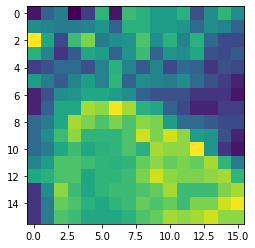

In [105]:
image_blocks = np.empty(shape=(198, 16, 256)) # [images, blocks, pixels]

# Find indices for each block
idxs = np.zeros(shape=(16,256), dtype=int)
i = 0
for row in range(4):
    for col in range(4):
        empty = np.zeros(shape=(64,64))
        empty[row*16:row*16+16, col*16:col*16+16] = 1
        idxs[i] = np.argwhere(empty.flatten()==1)[:,0]

        i+=1


for i, image in enumerate(catsndogs.iterrows()):

    im = image[1]
    for j in range(16):
        image_blocks[i,j,:] = im[idxs[j]]


plt.imshow(image_blocks[0,0,:].reshape((16,16), order='F'))

In [140]:
# 2b) Comparing/testing blocks & methods
t_acc = np.empty(shape=(0,0))
tr_acc = np.empty(shape=(0,0))
t_misl = np.empty(shape=(0,0))
tr_misl = np.empty(shape=(0,0))

for block in range(16):
    x = normalize(image_blocks[:,block,:].reshape((198,256)))

    test_acc, train_acc, test_mislab, train_mislab = analyze_separation(x,labels, repetitions=100, return_train=True)
    t_acc = np.append(t_acc, test_acc)
    


{'knn': 0.7289999999999998, 'lr': 0.6159999999999995, 'rf': 0.7527499999999995}
{'knn': 0.6177499999999995, 'lr': 0.5942499999999994, 'rf': 0.6202499999999996}
{'knn': 0.5797499999999994, 'lr': 0.5437499999999996, 'rf': 0.5944999999999998}
{'knn': 0.5427499999999997, 'lr': 0.5312499999999997, 'rf': 0.5482499999999997}
{'knn': 0.6749999999999994, 'lr': 0.6094999999999994, 'rf': 0.7139999999999997}
{'knn': 0.6937499999999996, 'lr': 0.6482499999999999, 'rf': 0.7572499999999996}
{'knn': 0.7152499999999997, 'lr': 0.6827499999999999, 'rf': 0.7417499999999999}
{'knn': 0.6452499999999994, 'lr': 0.5689999999999997, 'rf': 0.7019999999999996}
{'knn': 0.7289999999999998, 'lr': 0.6282499999999996, 'rf': 0.7184999999999996}
{'knn': 0.6819999999999992, 'lr': 0.6362499999999995, 'rf': 0.7444999999999999}
{'knn': 0.6894999999999994, 'lr': 0.6989999999999996, 'rf': 0.7187499999999999}
{'knn': 0.5904999999999995, 'lr': 0.6044999999999995, 'rf': 0.6909999999999993}
{'knn': 0.8047499999999999, 'lr': 0.5529

In [142]:
# 2b) Extracting block with best acc from t_acc
maxs = {
    'knn':0, 
    'lr':0, 
    'rf':0
    }
max_av = 0
ids = {
    'knn':0, 
    'lr':0, 
    'rf':0
}
for key in ['knn', 'lr', 'rf']:
    for i, accs in enumerate(t_acc):

        if accs[key] > maxs[key]:
            maxs[key] = accs[key]
            ids[key] = i

        if np.mean(list(accs.values())) > max_av:
            max_av = np.mean(list(accs.values()))
            max_mean_i = i


print(maxs)
print(ids)
print(f'Best overall: {max_mean_i} with average accuracy: {max_av}, {t_acc[max_mean_i]}')

{'knn': 0.8047499999999999, 'lr': 0.6989999999999996, 'rf': 0.7719999999999998}
{'knn': 12, 'lr': 10, 'rf': 12}
Best overall: 6 with average accuracy: 0.7132499999999998, {'knn': 0.7152499999999997, 'lr': 0.6827499999999999, 'rf': 0.7417499999999999}


## 2c (10p)

Turn half of the images upside down.

What's the classification performance now (compared to noise free, uncontaminated data)? Which features are important now? Are upside down images over-represented among the misclassified observations.

{'knn': 0.6567499999999997, 'lr': 0.6374999999999995, 'rf': 0.6209999999999996}
/get_f_imp/: x, converted to np
/get_f_imp/: y, converted to np
ft. imp. bootstrap 0


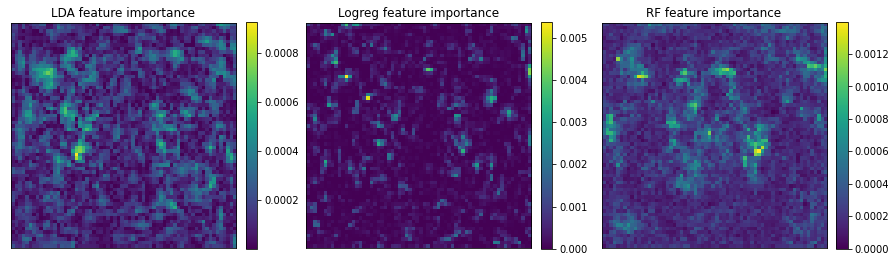

Fraction of upside-down images in the mislabeled set:
0.4852941176470588


In [209]:
# 2c) Flips half of images upside down, and check classification performance
def flip_half():
    ud_images = deepcopy(catsndogs)
    ud_idxs = np.random.choice(a=198, size=99, replace=False)

    for id in ud_idxs:
        np_im = ud_images.iloc[id].to_numpy().reshape((64,64))
        ud_im = np.flip(np_im, axis=1)
        ud_images.iloc[id] = ud_im.flatten()
    return ud_images

ud_images = flip_half()

ud_accs, ud_misl = analyze_separation(ud_images, labels, repetitions=100)

lda_cs_mean, lr_cs_mean, rf_cs_mean = get_f_imp(ud_images, labels, repetitions=50)
plot_f_imp(lda_cs_mean, lr_cs_mean, rf_cs_mean)

cons_misl_ud = find_mislabeling(ud_misl, consistency_threshold=1)

print(f'Fraction of upside-down images in the mislabeled set:\n{len(np.intersect1d(cons_misl_ud, ud_idxs))/len(cons_misl_ud)}')

## 2d (10p)


We can turn some of the features into noise features by changing their value to a random value drawn from U[0,256]. That, is, for each noise feature (pixel), change the values to randomly chosen values across all images.

For a sequence of increasing number (at least 5 levels) of randomly selected pixels to be replaced by noise features, investigate the classification performance and feature selection and selection stability.

[409, 1228, 2048, 2867, 3686, 4096]
{'knn': 0.7695000000000001, 'lr': 0.7537499999999995, 'rf': 0.7327499999999996}
ft. imp. bootstrap 0


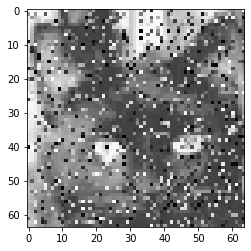

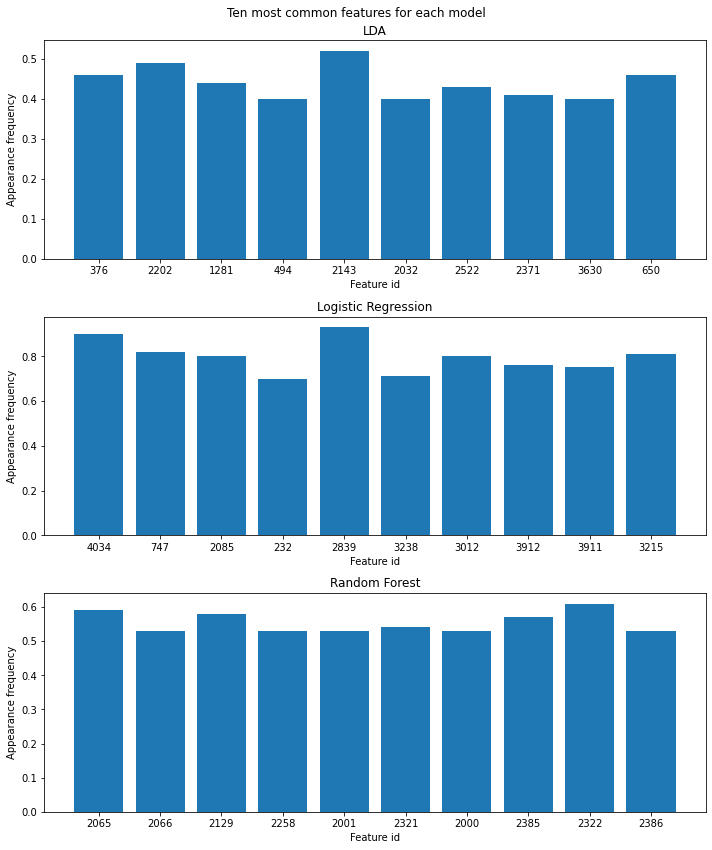

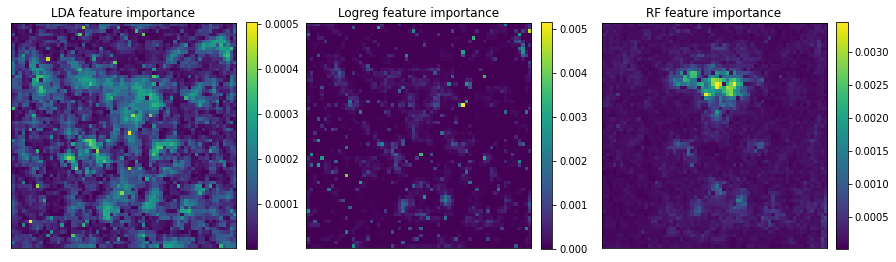

{'knn': 0.7602499999999994, 'lr': 0.7549999999999997, 'rf': 0.7352499999999993}
ft. imp. bootstrap 0


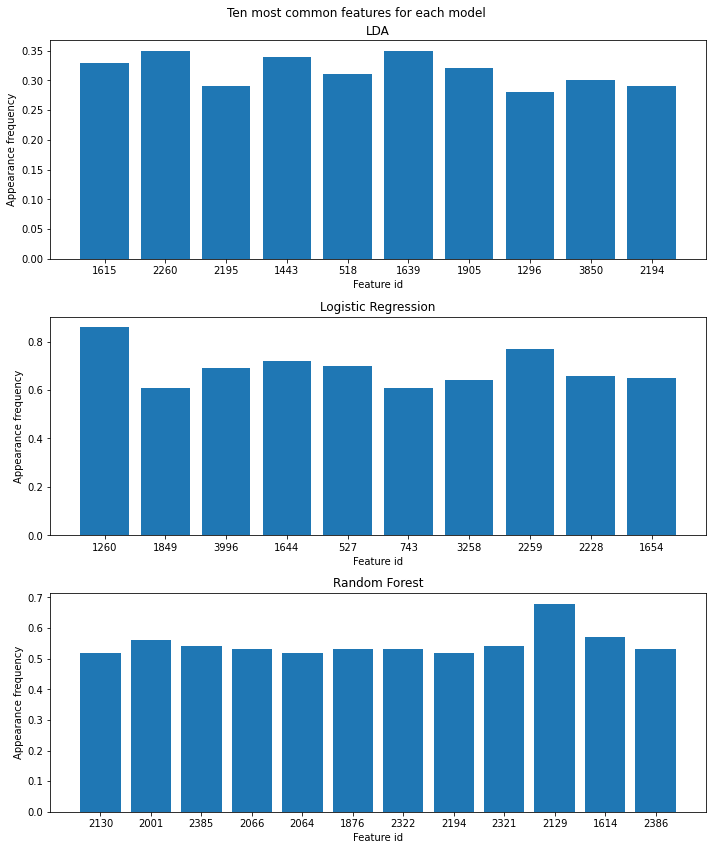

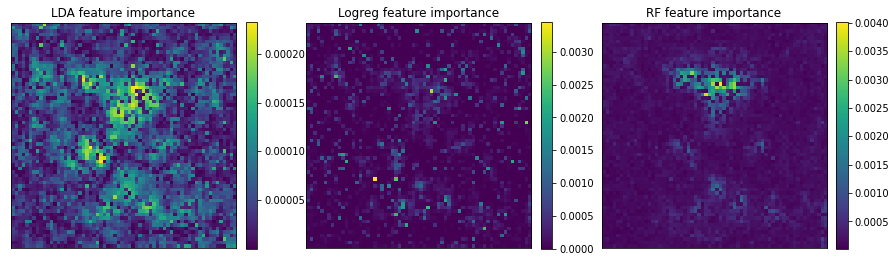

{'knn': 0.7672499999999999, 'lr': 0.7447499999999997, 'rf': 0.7169999999999996}
ft. imp. bootstrap 0


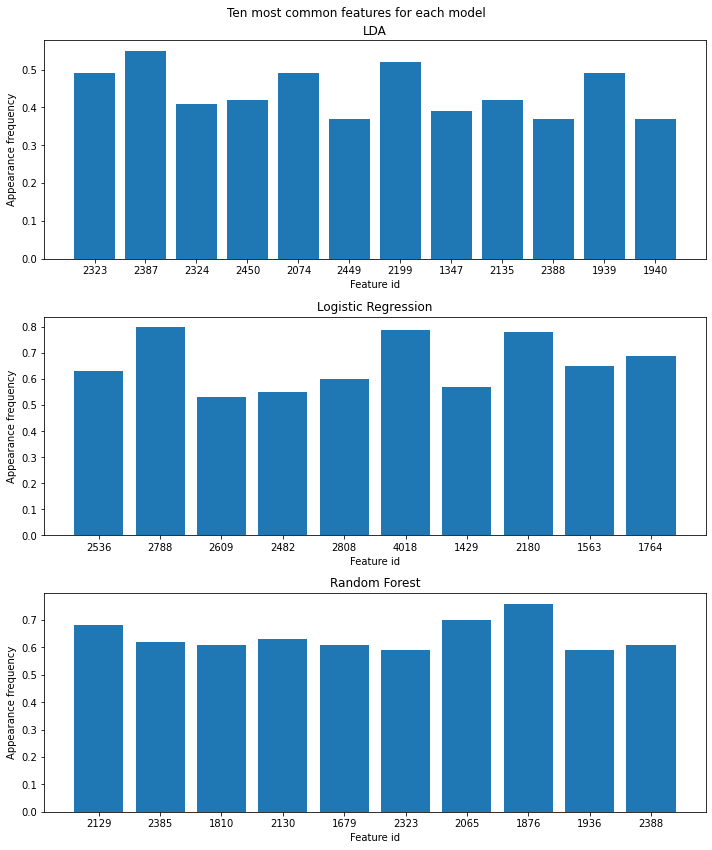

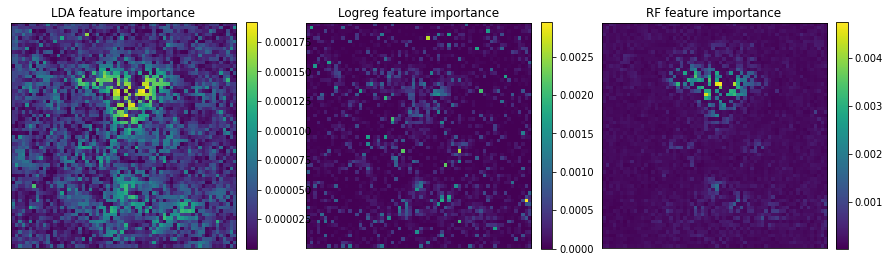

{'knn': 0.7844999999999996, 'lr': 0.7449999999999991, 'rf': 0.7354999999999997}
ft. imp. bootstrap 0


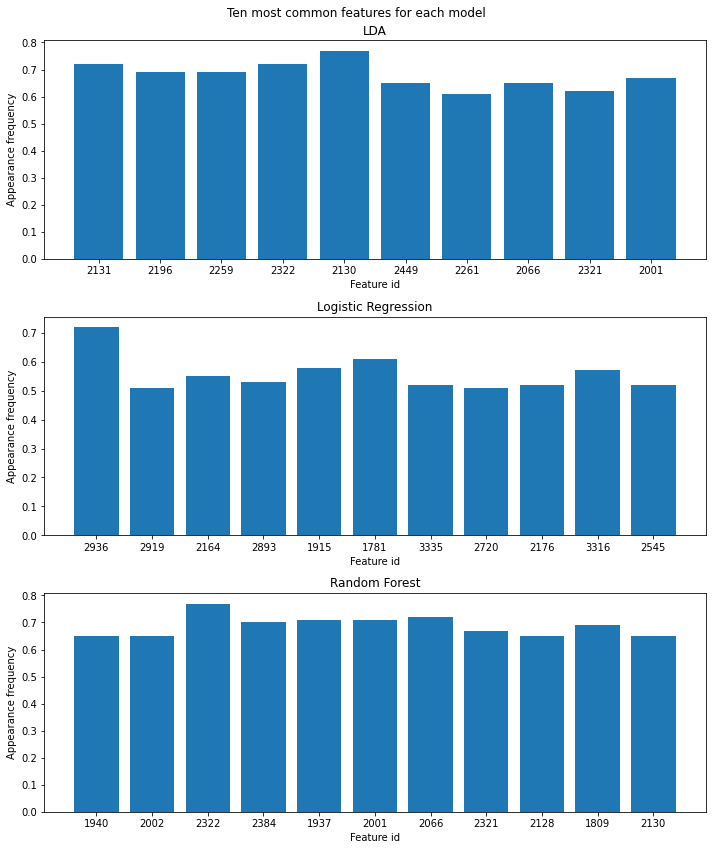

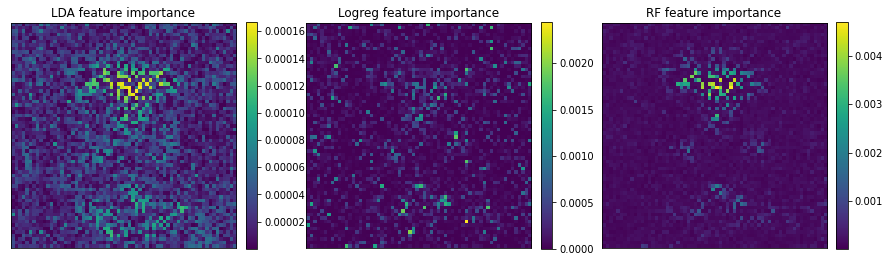

{'knn': 0.6512499999999996, 'lr': 0.6762499999999995, 'rf': 0.6862499999999995}
ft. imp. bootstrap 0


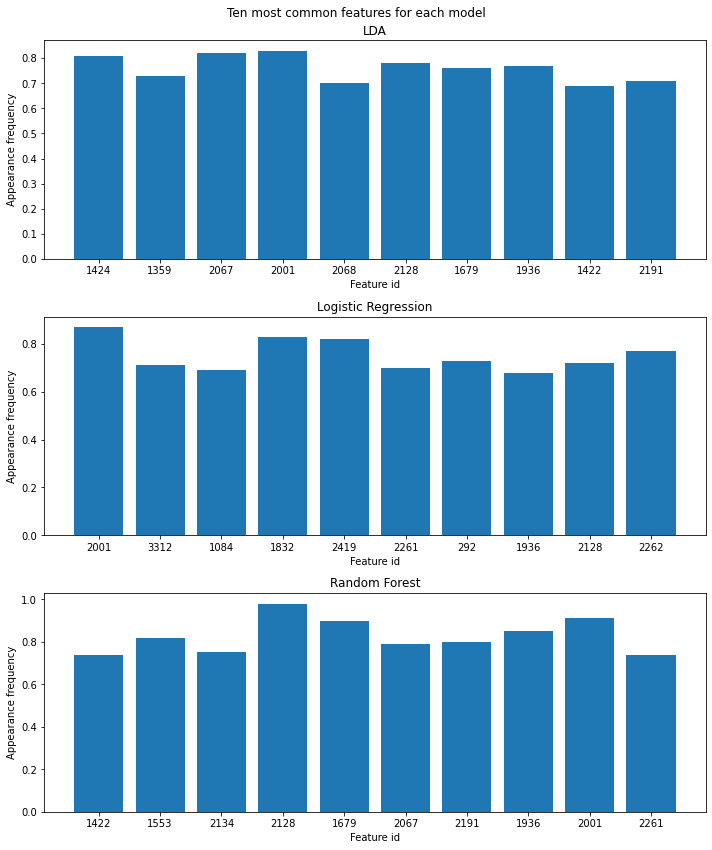

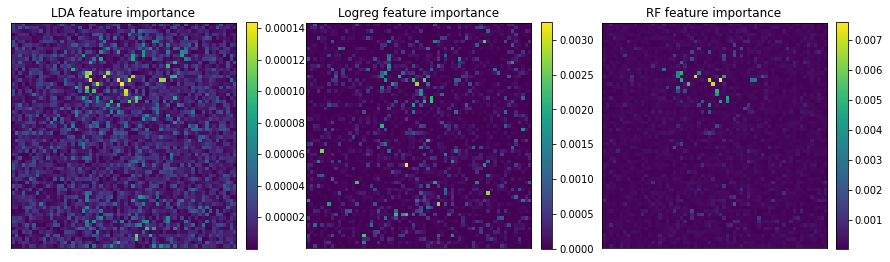

{'knn': 0.5052499999999996, 'lr': 0.48974999999999974, 'rf': 0.4872499999999996}
ft. imp. bootstrap 0


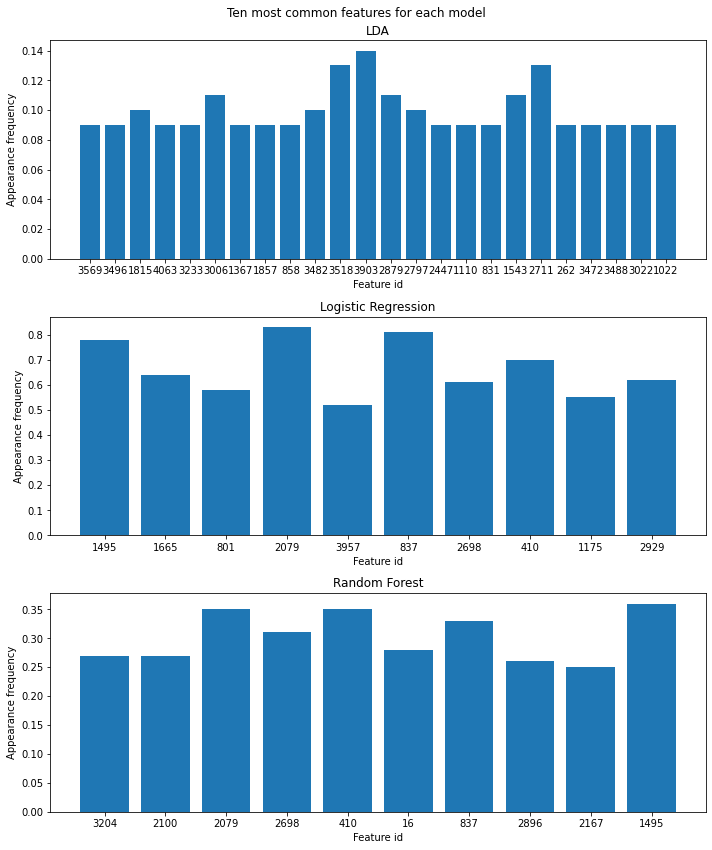

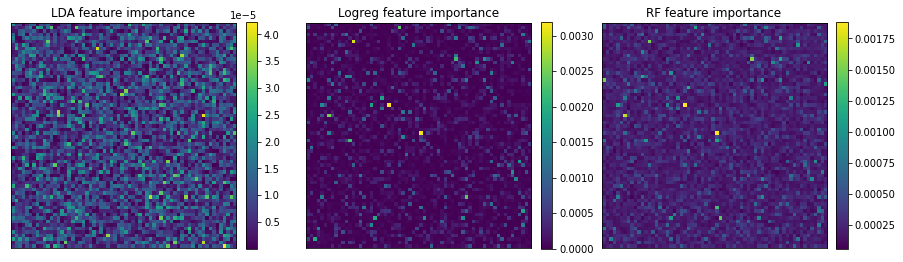

In [331]:
# Turn features into noise and test classification, feature selection, and selection stability
def apply_noise(n):
    noised_images = deepcopy(catsndogs)
    ns_idxs = np.random.choice(a=4096, size=n, replace=False)

    cols = noised_images.columns
    for col in noised_images[cols[ns_idxs]]:
        noised_images[col] = np.random.randint(low=0, high=255, size=198)

    return noised_images, ns_idxs

ns_ims, ids = apply_noise(1000)

plt.imshow(ns_ims.iloc[1].to_numpy().reshape((64,64), order='F'), cmap='gray')

nps = 4096
# Sequence of increasing number of noisy pixels
n_noise_list = [int(n) for n in [1/10*nps,3/10*nps, 5/10*nps, 7/10*nps, 9/10*nps, nps]]
print(n_noise_list)

ns_t_acc = list(np.zeros(shape=(len(n_noise_list))))
ns_cons_misl = np.zeros(shape=(len(n_noise_list), 1))
for i, n in enumerate(n_noise_list):
    noisy_images, ns_ids = apply_noise(n)
    
    # Investigate classification performance,
    ns_t_acc[i], ns_t_mislab = analyze_separation(noisy_images, labels, repetitions=100)

    # Feature selection and selection stability
    ns_cons_misl = find_mislabeling(ns_t_mislab, consistency_threshold=1)
    lda_c_m, lr_c_m, rf_c_m = get_f_imp(noisy_images, labels, repetitions=100)
    plot_f_imp(lda_c_m, lr_c_m, rf_c_m)

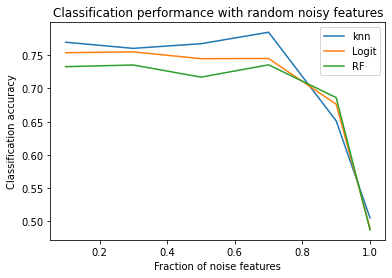

In [345]:
def plot_acc_over_noise(n_noise_list, ns_t_acc, title=''):
    fig, ax = plt.subplots(nrows=1, ncols=1)

    knn_accs = []
    lr_accs = []
    rf_accs = []

    for i, accs in enumerate(ns_t_acc):
        knn_accs.append(accs['knn'])
        lr_accs.append(accs['lr'])
        rf_accs.append(accs['rf'])

    ax.plot(n_noise_list, knn_accs, label='knn')
    ax.plot(n_noise_list, lr_accs, label='Logit')
    ax.plot(n_noise_list, rf_accs, label='RF')

    ax.set_ylabel('Classification accuracy')
    ax.set_xlabel('Fraction of noise features')

    ax.legend()
    ax.set_title(title)

    plt.show()
plot_acc_over_noise([n_f/4096 for n_f in n_noise_list], ns_t_acc, title='Classification performance with random noisy features')

## 2e (10p)

Instead of randomly selecting pixels to convert to noise features, what if you create noise features in a structured fashion (immitating a corruption of the images). You can choose to do this in any way you like (e.g. pixel blocks, pixel rows or columns etc). For the same number of noise feature levels as in 2e, create a scenario of structured noise feature location that leads to worsening performance compared to the results in 2e. Explain your findings.

{'knn': 0.7427499999999997, 'lr': 0.7449999999999997, 'rf': 0.7392499999999999}
{'knn': 0.7722499999999995, 'lr': 0.7377499999999996, 'rf': 0.7292499999999994}
{'knn': 0.7575, 'lr': 0.6782499999999996, 'rf': 0.7212499999999994}
{'knn': 0.6032499999999997, 'lr': 0.6324999999999998, 'rf': 0.6629999999999997}
{'knn': 0.5812499999999999, 'lr': 0.5729999999999998, 'rf': 0.5454999999999998}


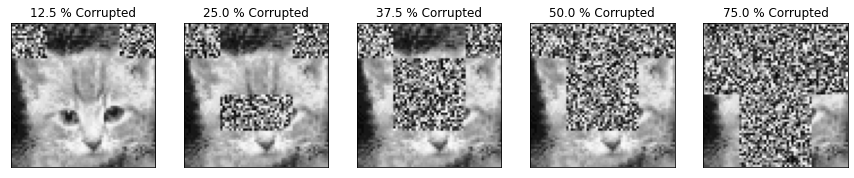

In [316]:
# Corrupt blocks, first find blocks
corrupted_ims = deepcopy(catsndogs)


i = 0
empty = np.zeros(shape=(16,64,64))
for row in range(4):
    for col in range(4):
        
        empty[i,row*16:row*16+16, col*16:col*16+16] = 1
        idxs[i] = np.argwhere(empty[i].flatten()==1)[:,0]
        i += 1

# Change values of blocks to images
def noise_blocks(i_blocks):
    for id in i_blocks:
        for i, _ in enumerate(corrupted_ims.iterrows()):
            corrupted_ims.iloc[i] = np.where(empty[id,:,:].flatten()==1, np.random.randint(low=0, high=255, size=4096), corrupted_ims.iloc[i].to_numpy())
    return corrupted_ims

block_seq = [
    [0,12],
    [0,6,10,12],
    [0,5,6,9,10,12],
    [0,4,5,6,8,9,10,12],
    [0,1,4,5,6,7,8,9,10,11,12,13]
]

fig, axs = plt.subplots(nrows=1, ncols=len(block_seq), figsize=(15,4))
crpt_t_acc = list(np.zeros(shape=(len(block_seq))))
for i, seq in enumerate(block_seq):
    corrupt_ims = noise_blocks(seq)

    axs[i].imshow(corrupted_ims.iloc[0].to_numpy().reshape((64,64), order='F'), cmap='gray')
    axs[i].get_xaxis().set_visible(False)
    axs[i].get_yaxis().set_visible(False)
    axs[i].set_title(f'{100*len(seq)/16} % Corrupted')

    crpt_t_acc[i], _ = analyze_separation(corrupt_ims, labels, repetitions=100)
    
plt.show()

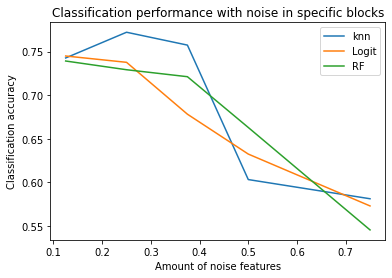

In [343]:
plot_acc_over_noise([len(seq)/16 for seq in block_seq], crpt_t_acc, title='Classification performance with noise in specific blocks')

## 2f (10p)

Finally, we turn to the pixels. The 64 times 64 (4096) pixels vary across images of cats and dogs. Explore the data set from the pixel perspective - that is, treat the pixels as 4096 observations to be clustered in 198-dimensional space.

Are there pixel clusters? What do they represent? How many clusters? Do these differ for cat and dog images? Is your answer to this question sensitive to the choice of metric and/or method?

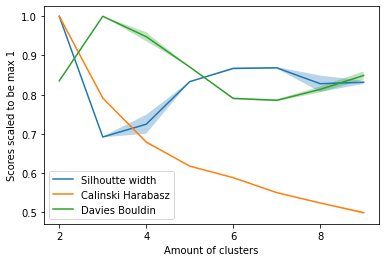

In [23]:
from copy import deepcopy
pixel_df = normalize(deepcopy(catsndogs).transpose())

# First find out if there are clusters/how many
score_n_clusters(pixel_df, 10, 5)

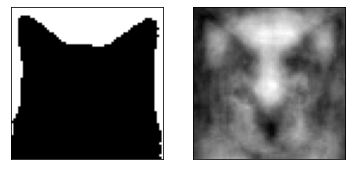

In [62]:
# What do the pixel clusters represent?
# Plot pixels as their respective cluster labels, hopefully 2 clusters

pixel_df = deepcopy(catsndogs).transpose()
km_p = KMeans(n_clusters=2).fit(pixel_df)

fig, axs = plt.subplots(nrows=1, ncols=2)

axs[0].imshow(km_p.labels_.reshape(64,64, order='F'), cmap='gray')
axs[0].get_xaxis().set_visible(False)
axs[0].get_yaxis().set_visible(False)

axs[1].imshow(catsndogs.mean().to_numpy().reshape(64, 64, order='F'), cmap='gray')
axs[1].get_xaxis().set_visible(False)
axs[1].get_yaxis().set_visible(False)
plt.show()

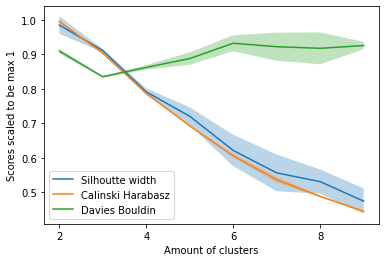

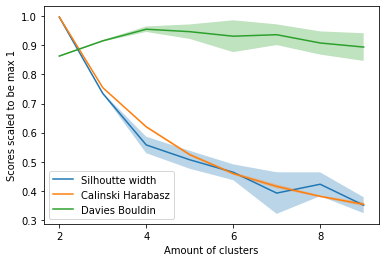

In [50]:
# Do these differ for cat and dog images
# Same thing for split dataset?
score_n_clusters(cats, 10, 5)
score_n_clusters(dogs, 10, 5)

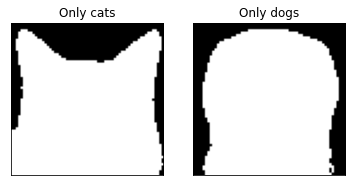

In [59]:
cats_p = normalize(deepcopy(cats).transpose())
dogs_p = normalize(deepcopy(dogs).transpose())


km_p_c = KMeans(n_clusters=2).fit(cats_p)
km_p_d = KMeans(n_clusters=2).fit(dogs_p)

fig, axs = plt.subplots(nrows=1, ncols=2)

axs[0].imshow(km_p_c.labels_.reshape(64,64, order='F'), cmap='gray')
axs[0].set_title('Only cats')
axs[1].imshow(km_p_d.labels_.reshape(64,64, order='F'), cmap='gray')
axs[1].set_title('Only dogs')
for ax in axs:
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [ ]:
# Is your answer sensitive to the choice of metric and/or method?
# Normalization changes outcome significantly for dogs, not for the others
# Vet inte hur man ska göra med den biten riktigt